In [2]:
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [3]:
# Load players dataset into notebook
players <- read_csv("players.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
# Wrangle data so there are no values with 'NA'
players <- players |>
  filter(!is.na(Age)) |>
  filter(!is.na(played_hours))

The data is in tidy format, as each row depicts a single observation (a unique player), each column represents a single variable (age, name, etc.), and each cell contains a single value.

In [5]:
# Selecting for variables of interest
players_data <- players |>
    select(played_hours, Age)

In [19]:
# Calculating summary statistics for variables of interest
played_hours_summary <- players |>
    summarise(
        played_hours_mean = mean(played_hours),
        played_hours_median = median(played_hours),
        played_hours_range = max(played_hours) - min(played_hours),
        played_hours_sd = sd(played_hours),
        played_hours_Q1 = quantile(played_hours, 0.25),
        played_hours_Q2 = quantile(played_hours, 0.75)) |>
        round(2)
played_hours_summary

age_summary <- players |>
    summarise(
        age_mean = mean(Age),
        age_median = median(Age),
        age_range = max(Age) - min(Age),
        age_sd = sd(Age),
        age_Q1 = quantile(Age, 0.25),
        age_Q2 = quantile(Age, 0.75)) |>
        round(2)
age_summary


played_hours_mean,played_hours_median,played_hours_range,played_hours_sd,played_hours_Q1,played_hours_Q2
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5.9,0.1,223.1,28.5,0,0.6


age_mean,age_median,age_range,age_sd,age_Q1,age_Q2
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
21.14,19,49,7.39,17,22.75


### Figure 1: Scatterplot showing the relationship between Age and Hours Played with trend line

`geom_smooth()` using formula = 'y ~ x'


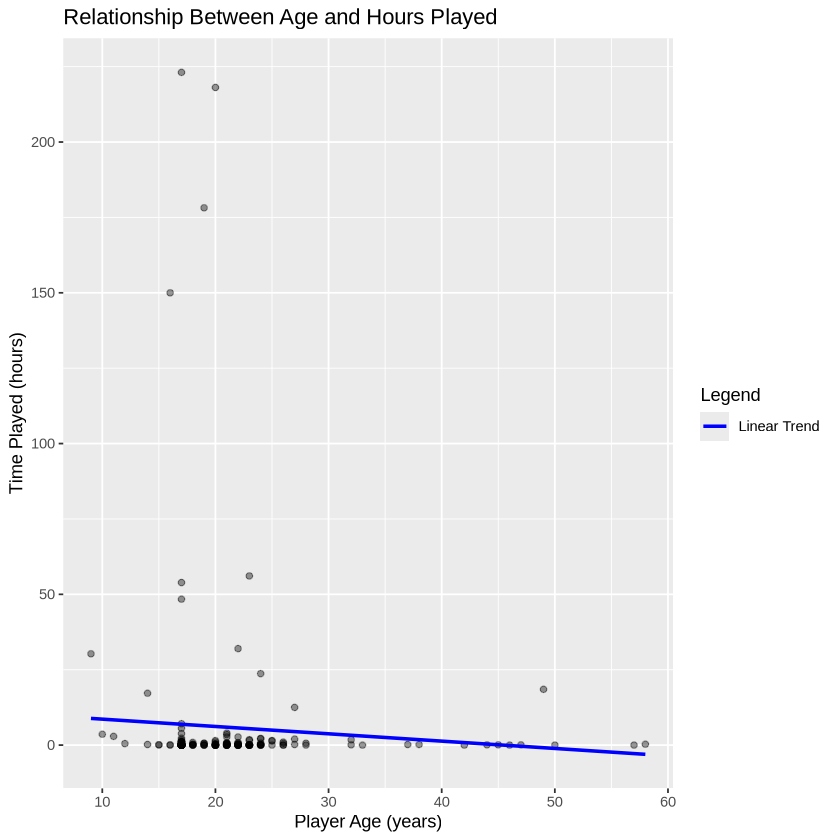

In [20]:
ggplot(players, aes(x=Age, y=played_hours)) +
    geom_point(alpha = 0.4) +
    geom_smooth(aes(colour = "Linear Trend"), method = "lm", se = FALSE) +
    scale_colour_manual(values = c("Linear Trend" = "blue"), name = "Legend") +
    labs(title = "Relationship Between Age and Hours Played",
         x = "Player Age (years)",
         y = "Time Played (hours)")

### Figure 2: Distribution of Player Ages

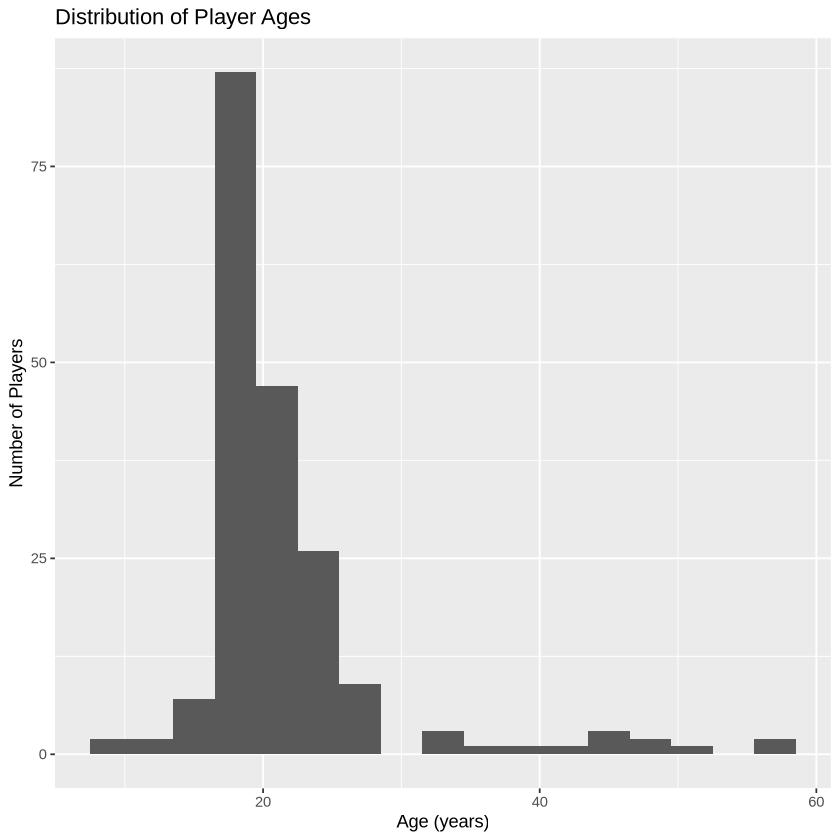

In [21]:
ggplot(players_data, aes(x = Age)) +
  geom_histogram(binwidth = 3) +
  labs(title = "Distribution of Player Ages", x = "Age (years)", y = "Number of Players")

### Figure 3: Distribution of Weekly Hours Played

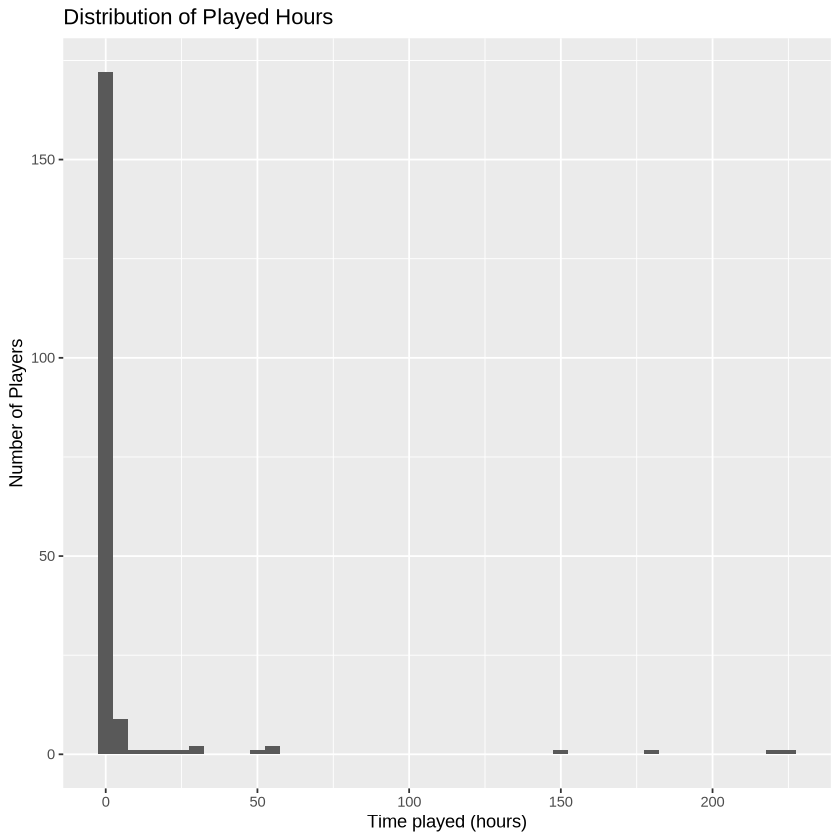

In [66]:
ggplot(players_data, aes(x = played_hours)) +
  geom_histogram(binwidth = 5) +
  labs(title = "Distribution of Played Hours", x = "Time played (hours)", y = "Number of Players")

As can be seen from figure 3 and the summary statistics, most players play a very low amount of hours, with the median being 0.1 hours and the first quartile being 0 hours. In addition to this, the vast majority of players are around 19-20 years of age, as can be seen from figure 2. These factors combined cause the majority of data points in figure 1 to cluster in one area, making it difficult to see a clear trend. There is a slight negative relationship between Age and played hours, however this relationship is weak due to the high variability in hours played among younger players and the scarcity of data for older players.

### Figure 4: Average daily time spent playing games per capita in the United States in 2024, by age group
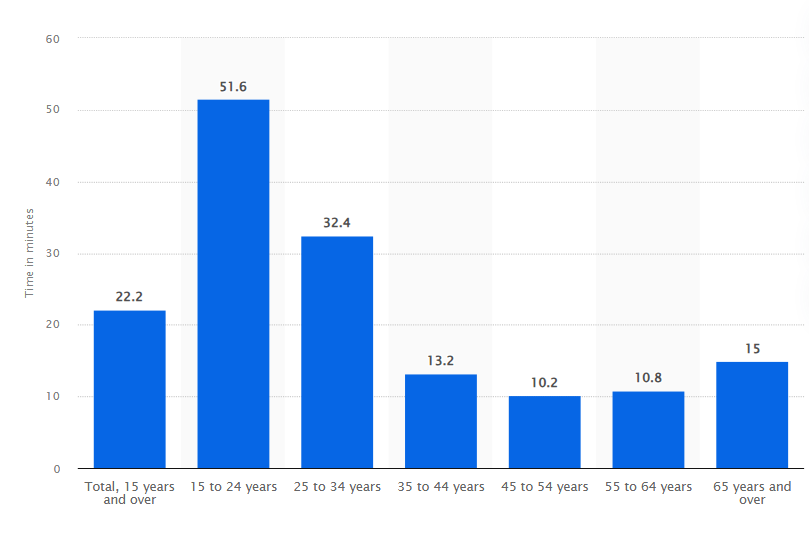
Source: Bureau of Labor Statistics (2024)

Figure 4 shows that there is a strong negative relationship between daily time spent playing video games and age. Because Minecraft is a video game, it would be reasonable to assume that amount of time spent playing Minecraft vs. Age should show a similar trend. So although the players dataset does not show a strong relationship between time played and age due to it being a small dataset, age can be chosen as a good predictor variable of time spent playing Minecraft.

In [29]:
# Splitting dataset into training and testing
players_split <- initial_split(players_data, prop = 0.7, strata = played_hours)
players_train <- training(players_split)
players_test <- testing(players_split)

In [90]:
# Training, evaluating, and tuning the model
players_recipe <- recipe(played_hours ~ Age, data = players_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

players_vfold <- vfold_cv(players_train, v = 10, strata = played_hours)

players_wkflw <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec)    

gridvals <- tibble (neighbors = seq(from = 1, to = 100, by = 3))

players_results <- players_wkflw |>
    tune_grid(resamples = players_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

players_min <- players_results |>
    filter(mean == min(mean))

kmin <- players_min |> pull (neighbors)

kmin

[1] 31

In [99]:
# Evaluate on the test set
players_spec2 <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) |>
    set_engine("kknn") |>
    set_mode("regression")

players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec2) |>
    fit(data = players_train)

players_preds <- players_fit |>
    predict(players_test) |>
    bind_cols(players_test)

players_summary <- players_preds |>
    metrics(truth = played_hours, estimate = .pred) |>
    filter (.metric == "rmse")

players_summary

# results in RMSPE on test data

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,40.06252


### Figure 5: Comparison of Actual and Predicted Hours Played vs Age

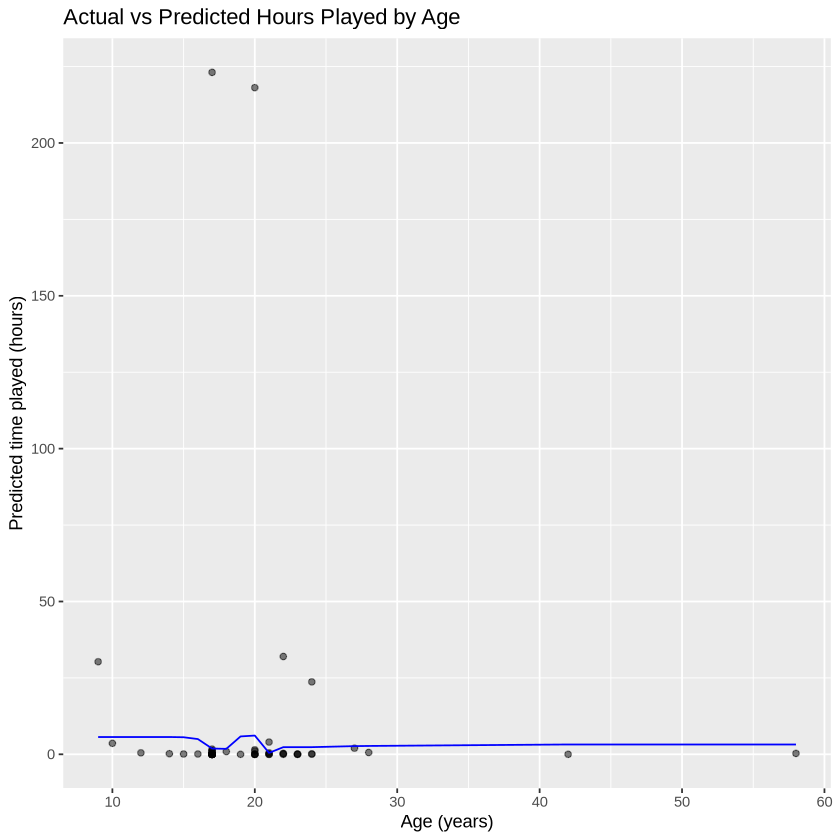

In [107]:
players_plot <- players_preds |>
    ggplot(aes(x=Age, y = played_hours)) +
    geom_point(alpha = 0.5) +
    geom_line(aes(y=.pred), color = "blue") +
    labs(x = "Age (years)", y = "Predicted time played (hours)", title = "Actual vs Predicted Hours Played by Age")
    
players_plot

## References

Bureau of Labor Statistics. (September 8, 2025). Average daily time spent playing games per capita in the United 
    States in 2024, by age group (in minutes) [Graph]. In Statista. Retrieved December 01, 2025, from 
    https://www.statista.com/statistics/789835/average-daily-time-playing-games-us-by-age/